<a href="https://colab.research.google.com/github/yshnxd/solaris/blob/main/SOLARISSS%20stablezzz%20finalzzzzz%2080%20%25%20with%20results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Libraries

In [1]:
# === STEP 0: Setup Libraries ===
# Core
import numpy as np
import pandas as pd
import gc
import os
import warnings
warnings.filterwarnings("ignore")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Technical indicators & TA-Lib alternative
!pip install ta --quiet
import ta

# Machine Learning
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, mean_absolute_error, mean_squared_error
)

# XGBoost
!pip install xgboost --quiet
from xgboost import XGBClassifier, XGBRegressor

# Deep Learning (TensorFlow/Keras)
!pip install tensorflow --quiet
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, Conv1D, MaxPooling1D,
    LSTM, Input, BatchNormalization, GlobalAveragePooling1D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Utilities for reproducibility
import random
import tensorflow as tf

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

print("✅ Libraries loaded successfully.")


  Preparing metadata (setup.py) ... done
✅ Libraries loaded successfully.


# Collect Data

In [2]:
# === STEP 1: Data Collection (Hourly) ===
!pip install yfinance --quiet
import yfinance as yf
from datetime import datetime
import pandas as pd
import os

# Target + market context tickers
tickers = ["AAPL", "SPY", "TSLA", "NVDA", "QQQ"]  # note: ^VIX for Yahoo
interval = "60m"  # 1-hour bars
period = "729d"   # max allowed for hourly

data_dict = {}
print("Downloading hourly data...")
for t in tickers:
    try:
        df = yf.download(t, interval=interval, period=period, progress=False)
        df.dropna(inplace=True)
        df.index = df.index.tz_localize(None)
        data_dict[t] = df
        print(f"{t}: {df.shape[0]} rows from {df.index.min()} to {df.index.max()}")
    except Exception as e:
        print(f"❌ Failed to get {t}: {e}")
# ✅ Replace old close_df creation with this
target_index = data_dict["AAPL"].index
aligned_close = pd.DataFrame(index=target_index)

for t, df in data_dict.items():
    aligned_close[t] = df.reindex(target_index)['Close']

print("\nSample aligned close prices:")
print(aligned_close.tail())

# Save raw hourly data
os.makedirs("data_raw", exist_ok=True)
for t, df in data_dict.items():
    df.to_csv(f"data_raw/{t}_60m.csv")
print("\n✅ Hourly data downloaded and saved to 'data_raw/'")


AAPL: 5075 rows from 2022-09-20 13:30:00 to 2025-08-15 19:30:00
SPY: 5075 rows from 2022-09-20 13:30:00 to 2025-08-15 19:30:00
TSLA: 5075 rows from 2022-09-20 13:30:00 to 2025-08-15 19:30:00
NVDA: 5075 rows from 2022-09-20 13:30:00 to 2025-08-15 19:30:00
QQQ: 5075 rows from 2022-09-20 13:30:00 to 2025-08-15 19:30:00

Sample aligned close prices:
                           AAPL         SPY        TSLA        NVDA  \
Datetime                                                              
2025-08-15 15:30:00  230.740005  643.289978  327.940002  178.929993   
2025-08-15 16:30:00  230.570007  644.165405  330.899994  179.700104   
2025-08-15 17:30:00  230.850006  644.530029  329.829987  180.179993   
2025-08-15 18:30:00  231.360001  643.799988  329.059998  179.970001   
2025-08-15 19:30:00  231.649994  643.460022  330.600006  180.440002   

                            QQQ  
Datetime                         
2025-08-15 15:30:00  576.309998  
2025-08-15 16:30:00  577.275024  
2025-08-15 17:30:0

#Feature Creation

Creating Features

In [3]:
all_feat_data = []

# Forward-fill aligned_close once globally
aligned_ffill = aligned_close.ffill()

for ticker in aligned_ffill.columns:
    if aligned_ffill[ticker].isna().all():
        continue

    price_series = aligned_ffill[ticker]
    feat_tmp = pd.DataFrame(index=price_series.index)

    # Lag returns
    for lag in [1, 3, 6, 12, 24]:
        feat_tmp[f"ret_{lag}h"] = price_series.pct_change(lag)

    # Rolling volatility
    for window in [6, 12, 24]:
        feat_tmp[f"vol_{window}h"] = price_series.pct_change().rolling(window).std()

    # Technical indicators
    feat_tmp["rsi_14"] = ta.momentum.RSIIndicator(price_series, window=14).rsi()
    macd = ta.trend.MACD(price_series)
    feat_tmp["macd"] = macd.macd()
    feat_tmp["macd_signal"] = macd.macd_signal()

    # Moving averages
    for w in [5, 10, 20]:
        feat_tmp[f"sma_{w}"] = price_series.rolling(w).mean()
        feat_tmp[f"ema_{w}"] = price_series.ewm(span=w, adjust=False).mean()

    # Volume features
    if ticker in data_dict and "Volume" in data_dict[ticker].columns:
        vol_series = data_dict[ticker].reindex(price_series.index)["Volume"].ffill()Cross-Asset Contextual Features: To capture broader market interactions, one-hour returns of SPY, QQQ, NVDA, and the volatility index (VIX) were aligned and included as contextual explanatory variables:
        feat_tmp["vol_change_1h"] = vol_series.pct_change()
        feat_tmp["vol_ma_24h"] = vol_series.rolling(24).mean()

    # Cross-asset returns — from the globally ffilled dataframe
    for asset in ["SPY", "QQQ", "NVDA"]:
        if asset in aligned_ffill.columns:
            feat_tmp[f"{asset}_ret_1h"] = aligned_ffill[asset].pct_change()

    if "^VIX" in aligned_ffill.columns:
        feat_tmp["vix_ret_1h"] = aligned_ffill["^VIX"].pct_change()

    # Calendar features
    feat_tmp["hour"] = feat_tmp.index.hour
    feat_tmp["day_of_week"] = feat_tmp.index.dayofweek

    # Only drop rows with NaNs in features for THIS ticker
    feat_tmp = feat_tmp.dropna(subset=[col for col in feat_tmp.columns if col not in ["datetime", "ticker"]])

    feat_tmp["datetime"] = feat_tmp.index
    feat_tmp["ticker"] = tickerCross-Asset Contextual Features: To capture broader market interactions, one-hour returns of SPY, QQQ, NVDA, and the volatility index (VIX) were aligned and included as contextual explanatory variables:

    all_feat_data.append(feat_tmp.reset_index(drop=True))

features_df = pd.concat(all_feat_data, ignore_index=True)

print(f"✅ Created features for {features_df['ticker'].nunique()} tickers")
print("Shape:", features_df.shape)
print(features_df.head())


✅ Created features for 5 tickers
Shape: (25210, 26)
     ret_1h    ret_3h    ret_6h   ret_12h   ret_24h    vol_6h   vol_12h  \
0  0.006804  0.005354  0.007740  0.008210 -0.034823  0.011265  0.008024   
1 -0.005307  0.000796 -0.017692  0.005465 -0.040462  0.006372  0.008163   
2  0.012726  0.014204  0.007085  0.022006 -0.014901  0.007212  0.008755   
3 -0.006773  0.000527  0.005885  0.013854 -0.025400  0.007447  0.009105   
4 -0.005993 -0.000162  0.000634  0.010893 -0.018636  0.007982  0.009266   

    vol_24h     rsi_14      macd  ...      ema_20  vol_change_1h  \
0  0.008250  47.831019 -0.843695  ...  151.731845       0.155673   
1  0.008276  44.579805 -0.811825  ...  151.649764       0.064564   
2  0.008375  52.817108 -0.624450  ...  151.758349       0.991185   
3  0.008409  48.621926 -0.553085  ...  151.758030      -0.467397   
4  0.008101  45.222387 -0.563423  ...  151.671123       0.085019   

     vol_ma_24h  SPY_ret_1h  QQQ_ret_1h  NVDA_ret_1h  hour  day_of_week  \
0  1.262300e+

Label Creation

In [4]:
# === LABEL CREATION FOR ALL TICKERS (pooled dataset) ===

horizon = 1               # predict 1 hour ahead
vol_lookback = 24         # hours to compute rolling volatility
vol_multiplier = 0.5      # threshold scaling vs volatility

all_data = []

for ticker in aligned_close.columns:
    # Skip if ticker is all NaN (e.g., ^VIX alignment issues)
    if aligned_close[ticker].dropna().empty:
        continue

    price_series = aligned_close[ticker]

    # Forward return
    future_price = price_series.shift(-horizon)
    future_ret = (future_price - price_series) / price_series

    # Volatility-based threshold
    rolling_vol = price_series.pct_change().rolling(vol_lookback).std()
    threshold = rolling_vol * vol_multiplier

    # Label creation
    label = future_ret.copy()
    label[future_ret > threshold] = 1    # Up
    label[future_ret < -threshold] = -1  # Down
    label[(future_ret <= threshold) & (future_ret >= -threshold)] = 0  # Neutral

    # Drop NaNs
    label = label.dropna()

    # Combine into dataframe
    df_tmp = pd.DataFrame({
        "datetime": label.index,
        "ticker": ticker,
        "price": price_series.loc[label.index],
        "label": label.values,
        "future_ret": future_ret.loc[label.index],
        "volatility": rolling_vol.loc[label.index]
    })

    all_data.append(df_tmp)

# Combine all tickers
labels_df = pd.concat(all_data, ignore_index=True)

print("Combined dataset shape:", labels_df.shape)
print(labels_df["label"].value_counts(normalize=True))
labels_df.head(10)


Combined dataset shape: (25370, 6)
label
 0.000000    0.532755
 1.000000    0.245250
-1.000000    0.217264
 0.001154    0.000039
 0.004992    0.000039
               ...   
-0.005434    0.000039
-0.013390    0.000039
-0.002570    0.000039
-0.006481    0.000039
 0.001337    0.000039
Name: proportion, Length: 123, dtype: float64


,datetime,ticker,price,label,future_ret,volatility
0,2022-09-20 13:30:00,AAPL,154.804993,0.011595,0.011595,NaN
1,2022-09-20 14:30:00,AAPL,156.600006,0.004310,0.004310,NaN
2,2022-09-20 15:30:00,AAPL,157.274994,-0.007852,-0.007852,NaN
3,2022-09-20 16:30:00,AAPL,156.039993,0.001154,0.001154,NaN
4,2022-09-20 17:30:00,AAPL,156.220093,0.004992,0.004992,NaN
5,2022-09-20 18:30:00,AAPL,157.000000,-0.000637,-0.000637,NaN
6,2022-09-20 19:30:00,AAPL,156.899994,0.003123,0.003123,NaN
7,2022-09-21 13:30:00,AAPL,157.389999,-0.007974,-0.007974,NaN
8,2022-09-21 14:30:00,AAPL,156.134995,0.006484,0.006484,NaN
9,2022-09-21 15:30:00,AAPL,157.147400,0.000538,0.000538,NaN


Scaling

# Preprocessing

Normalize Features

In [5]:
# Merge features with labels
df = features_df.merge(labels_df, on=["datetime", "ticker"], how="inner")

# Drop NaNs (just in case)
df = df.dropna()

# Separate features & labels
X = df.drop(columns=["datetime", "ticker", "label", "future_ret"])
y = df["label"]

print("X shape:", X.shape)
print("y distribution:\n", y.value_counts(normalize=True))


X shape: (25205, 26)
y distribution:
 label
 0.0    0.535529
 1.0    0.246181
-1.0    0.218290
Name: proportion, dtype: float64


Scale

In [6]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Merge features and labels
df = features_df.merge(labels_df, on=["datetime", "ticker"], how="inner")

# Sort by time
df = df.sort_values(["datetime", "ticker"]).reset_index(drop=True)

# Replace inf values with NaN
df = df.replace([np.inf, -np.inf], np.nan)

# Drop rows with NaNs
df = df.dropna()

# Separate features & target
X = df.drop(columns=["datetime", "ticker", "label", "future_ret"])
y = df["label"]

# Time-based split
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.15)

X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]

X_val = X.iloc[train_size:train_size + val_size]
y_val = y.iloc[train_size:train_size + val_size]

X_test = X.iloc[train_size + val_size:]
y_test = y.iloc[train_size + val_size:]

# Ensure all values are finite before scaling
assert np.isfinite(X_train.values).all(), "Found non-finite values in X_train!"

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"✅ Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print("Label distribution in Train:", y_train.value_counts(normalize=True))


✅ Train: (17631, 26), Val: (3778, 26), Test: (3779, 26)
Label distribution in Train: label
 0.0    0.525552
 1.0    0.252567
-1.0    0.221882
Name: proportion, dtype: float64


Sequence making - For LSTM AND CNN

In [7]:
import numpy as np

def create_sequences(X, y, seq_len=24):
    """
    Convert tabular (samples, features) into sequential (samples, seq_len, features)
    for CNN/LSTM, keeping labels aligned to the last timestep.
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])  # label at next hour
    return np.array(X_seq), np.array(y_seq)

# === Choose sequence length ===
SEQ_LEN = 24  # last 24 hours to predict next hour

# Reshape train/val/test sets
X_train_seq, y_train_seq = create_sequences(X_train, y_train.values, SEQ_LEN)
X_val_seq,   y_val_seq   = create_sequences(X_val,   y_val.values,   SEQ_LEN)
X_test_seq,  y_test_seq  = create_sequences(X_test,  y_test.values,  SEQ_LEN)

print(f"Train seq: {X_train_seq.shape}, Val seq: {X_val_seq.shape}, Test seq: {X_test_seq.shape}")


Train seq: (17607, 24, 26), Val seq: (3754, 24, 26), Test seq: (3755, 24, 26)


In [8]:
# CELL 1 — label encoding + class weights
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical

# mapping: -1 -> 0 (down), 0 -> 1 (neutral), 1 -> 2 (up)
label_map = { -1.0: 0, 0.0: 1, 1.0: 2 }

# If your y_* are numpy arrays (seq labels), convert
y_train_seq_mapped = np.vectorize(label_map.get)(y_train_seq)
y_val_seq_mapped   = np.vectorize(label_map.get)(y_val_seq)
y_test_seq_mapped  = np.vectorize(label_map.get)(y_test_seq)

# one-hot for Keras
y_train_cat = to_categorical(y_train_seq_mapped, num_classes=3)
y_val_cat   = to_categorical(y_val_seq_mapped, num_classes=3)
y_test_cat  = to_categorical(y_test_seq_mapped, num_classes=3)

# compute class weights from training sequence labels
classes = np.unique(y_train_seq_mapped)
class_weights = compute_class_weight("balanced", classes=classes, y=y_train_seq_mapped)
class_weights_dict = {int(c): w for c, w in zip(classes, class_weights)}
print("Class weights:", class_weights_dict)
print("Train class distribution:", np.bincount(y_train_seq_mapped) / len(y_train_seq_mapped))


Class weights: {0: np.float64(1.5052577583995896), 1: np.float64(0.6338012958963283), 2: np.float64(1.3194694244604317)}
Train class distribution: [0.22144602 0.52592719 0.2526268 ]


# Build the Model

CNN

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Activation, Dropout, SpatialDropout1D,
    GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Add, Multiply, Concatenate
)
from tensorflow.keras.regularizers import l2

# try to use AdamW (TF nightly / TF >=2.11 has experimental AdamW); fallback to classic Adam
try:
    from tensorflow.keras.optimizers import experimental as exp_optimizers
    AdamW = exp_optimizers.AdamW
    use_adamw = True
except Exception:
    from tensorflow.keras.optimizers import Adam
    AdamW = None
    use_adamw = False

def se_block(x, reduction=8):
    """Squeeze-and-Excitation block."""
    channels = int(x.shape[-1])
    se = GlobalAveragePooling1D()(x)
    se = tf.keras.layers.Dense(channels // reduction, activation='relu', kernel_initializer='he_normal')(se)
    se = tf.keras.layers.Dense(channels, activation='sigmoid', kernel_initializer='he_normal')(se)
    se = tf.keras.layers.Reshape((1, channels))(se)
    return Multiply()([x, se])

def residual_block(x, filters, kernel_size, dropout_rate=0.2, weight_decay=1e-4):
    shortcut = x
    # projection if channels mismatch
    if x.shape[-1] != filters:
        shortcut = Conv1D(filters, kernel_size=1, padding='same',
                          kernel_initializer='he_normal',
                          kernel_regularizer=l2(weight_decay))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Conv1D(filters, kernel_size=kernel_size, padding='same',
               kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # spatial dropout is preferable for time-series channels
    x = SpatialDropout1D(dropout_rate)(x)

    x = Conv1D(filters, kernel_size=kernel_size, padding='same',
               kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_cnn_enhanced(input_shape, n_classes=3, dropout_rate=0.25, weight_decay=1e-4):
    inp = Input(shape=input_shape)

    # optionally normalize channels at input
    x = BatchNormalization()(inp)

    # initial conv
    x = Conv1D(64, kernel_size=3, padding='same',
               kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # residual blocks (reduce complexity growth if dataset small)
    x = residual_block(x, 64, 3, dropout_rate=dropout_rate, weight_decay=weight_decay)
    x = residual_block(x, 128, 5, dropout_rate=dropout_rate, weight_decay=weight_decay)
    x = residual_block(x, 256, 3, dropout_rate=dropout_rate, weight_decay=weight_decay)

    # attention
    x = se_block(x, reduction=8)

    # pooling combination
    gap = GlobalAveragePooling1D()(x)
    gmp = GlobalMaxPooling1D()(x)
    x = Concatenate()([gap, gmp])  # combined representation

    x = Dense(256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(dropout_rate)(x)
    out = Dense(n_classes, activation='softmax')(x)

    model = Model(inp, out)

    # optimizer: try AdamW if available, otherwise Adam with weight decay via L2 above
    if use_adamw and AdamW is not None:
        opt = AdamW(learning_rate=1e-3, weight_decay=1e-5)
    else:
        opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Build model (example)
cnn_model = build_cnn_enhanced(input_shape=X_train_seq.shape[1:], n_classes=3, dropout_rate=0.25, weight_decay=1e-4)
cnn_model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 26)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 24, 26)    │        104 │ input_layer[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 24, 64)    │      5,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 64)    │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 24, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 24, 64)    │     12,352 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 64)    │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 24, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 24, 64)    │          0 │ activation_1[0][… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 24, 64)    │     12,352 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 64)    │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 24, 64)    │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 24, 128)   │     41,088 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 128)   │        512 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 24, 128)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 24, 128)   │          0 │ activation_3[0][… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 24, 128)   │     82,048 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 676,427 (2.58 MB)

 Trainable params: 673,687 (2.57 MB)

 Non-trainable params: 2,740 (10.70 KB)

LSTM

In [10]:
from tensorflow.keras.layers import (
    Input, Bidirectional, LSTM, GRU, Dense, Dropout,
    LayerNormalization, GlobalAveragePooling1D, GlobalMaxPooling1D,
    Concatenate, Attention
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_lstm_enhanced(input_shape, n_classes=3, dropout_rate=0.25):
    inp = Input(shape=input_shape)
    x = LayerNormalization()(inp)

    # First BiLSTM layer
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.2)(x)

    # Second BiGRU layer (faster and adds diversity in sequence modeling)
    x = Bidirectional(GRU(64, return_sequences=True))(x)
    x = Dropout(0.2)(x)

    # Self-Attention layer
    attn_data = Attention()([x, x])
    x = Concatenate()([x, attn_data])  # fuse original and attention output

    # Pooling
    x_avg = GlobalAveragePooling1D()(x)
    x_max = GlobalMaxPooling1D()(x)
    x = Concatenate()([x_avg, x_max])

    # Dense layers
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    out = Dense(n_classes, activation='softmax')(x)

    model = Model(inp, out)
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Instantiate model
lstm_model = build_lstm_enhanced(input_shape=X_train_seq.shape[1:], n_classes=3, dropout_rate=0.25)
lstm_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 24, 26)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 24, 26)    │         52 │ input_layer_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 24, 256)   │    158,720 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 24, 256)   │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 24, 128)   │    123,648 │ dropout_2[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 24, 128)   │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 24, 128)   │          0 │ dropout_3[0][0],  │
│ (Attention)         │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 24, 256)   │          0 │ dropout_3[0][0],  │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ concatenate_1[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ concatenate_1[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 512)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │    131,328 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     32,896 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 3)         │        387 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 447,031 (1.71 MB)

 Trainable params: 447,031 (1.71 MB)

 Non-trainable params: 0 (0.00 B)

XGBOOST

In [11]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ---- Map labels safely to integers 0,1,2 ----
label_map = {-1.0: 0, 0.0: 1, 1.0: 2}
# if y_train etc are pandas Series this is robust:
y_train_tab = pd.Series(y_train).map(label_map).astype('int').to_numpy()
y_val_tab   = pd.Series(y_val).map(label_map).astype('int').to_numpy()
y_test_tab  = pd.Series(y_test).map(label_map).astype('int').to_numpy()

# ---- Per-sample balanced weights (recommended for multiclass) ----
sample_weight_train = compute_sample_weight('balanced', y_train_tab)
# sample_weight_train is length n_train; pass it into .fit(..., sample_weight=...)

# ---- Defensive: compute per-class counts (avoid division by zero) ----
class_counts = np.bincount(y_train_tab, minlength=3)
total = len(y_train_tab)
n_classes = len(class_counts)
per_class_scale = np.where(class_counts == 0, 0.0, total / (n_classes * class_counts))
print("class_counts:", class_counts, "per_class_scale:", per_class_scale)

# If you prefer per-sample weights from per_class_scale:
sample_weight_from_scale = np.array([per_class_scale[c] for c in y_train_tab])

# ---- XGBoost classifier (multi-class) ----
xgb_clf = xgb.XGBClassifier(
    objective='multi:softprob',    # multiclass probability output
    num_class=3,                   # explicit number of classes (safe to include)
    n_estimators=1000,             # set high + use early stopping
    learning_rate=0.03,
    max_depth=6,
    min_child_weight=3,
    gamma=1,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    tree_method='hist',            # 'gpu_hist' if you have GPU
    eval_metric='mlogloss',
    use_label_encoder=False
)


class_counts: [3912 9266 4453] per_class_scale: [1.50230061 0.63425426 1.31978442]


# Train the model

CNN

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import tensorflow as tf
import datetime

# Enable mixed precision if supported
if tf.config.list_physical_devices('GPU'):
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Compile with lower LR initially for stability
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

rlr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

chk = ModelCheckpoint(
    filepath='best_cnn_full_model.keras',  # save full model, not just weights
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# TensorBoard logging
log_dir = "logs/cnn/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Training
cnn_history = cnn_model.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_val_seq, y_val_cat),
    epochs=100,
    batch_size=128,
    class_weight=class_weights_dict,
    callbacks=[es, rlr, chk, tb_callback],
    verbose=2
)


Epoch 1/100

Epoch 1: val_loss improved from inf to 1.39329, saving model to best_cnn_full_model.keras
138/138 - 52s - 374ms/step - accuracy: 0.3498 - loss: 1.5008 - val_accuracy: 0.5008 - val_loss: 1.3933 - learning_rate: 5.0000e-04
Epoch 2/100

Epoch 2: val_loss improved from 1.39329 to 1.38862, saving model to best_cnn_full_model.keras
138/138 - 39s - 280ms/step - accuracy: 0.3630 - loss: 1.4342 - val_accuracy: 0.5011 - val_loss: 1.3886 - learning_rate: 5.0000e-04
Epoch 3/100

Epoch 3: val_loss did not improve from 1.38862
138/138 - 30s - 218ms/step - accuracy: 0.3866 - loss: 1.4167 - val_accuracy: 0.3639 - val_loss: 1.4123 - learning_rate: 5.0000e-04
Epoch 4/100

Epoch 4: val_loss did not improve from 1.38862
138/138 - 29s - 211ms/step - accuracy: 0.4068 - loss: 1.4026 - val_accuracy: 0.3980 - val_loss: 1.4070 - learning_rate: 5.0000e-04
Epoch 5/100

Epoch 5: val_loss improved from 1.38862 to 1.35763, saving model to best_cnn_full_model.keras
138/138 - 30s - 214ms/step - accuracy: 

LSTM

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import tensorflow as tf
import datetime

# Enable mixed precision if GPU supports it (LSTMs benefit less than CNNs, but still good for speed)
if tf.config.list_physical_devices('GPU'):
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Compile LSTM with gradient clipping (helps with exploding gradients in RNNs)
lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4, clipnorm=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

rlr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

chk = ModelCheckpoint(
    filepath='best_lstm_full_model.keras',  # Save entire model
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# TensorBoard logging
log_dir = "logs/lstm/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Training
lstm_history = lstm_model.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_val_seq, y_val_cat),
    epochs=120,  # Give it more room to converge
    batch_size=96,  # Smaller batch size often helps LSTM generalization
    class_weight=class_weights_dict,
    callbacks=[es, rlr, chk, tb_callback],
    verbose=2
)


Epoch 1/120

Epoch 1: val_loss improved from inf to 1.08925, saving model to best_lstm_full_model.keras
184/184 - 32s - 174ms/step - accuracy: 0.4026 - loss: 1.0910 - val_accuracy: 0.3934 - val_loss: 1.0893 - learning_rate: 3.0000e-04
Epoch 2/120

Epoch 2: val_loss improved from 1.08925 to 1.08672, saving model to best_lstm_full_model.keras
184/184 - 41s - 221ms/step - accuracy: 0.4360 - loss: 1.0789 - val_accuracy: 0.3820 - val_loss: 1.0867 - learning_rate: 3.0000e-04
Epoch 3/120

Epoch 3: val_loss did not improve from 1.08672
184/184 - 41s - 225ms/step - accuracy: 0.4511 - loss: 1.0717 - val_accuracy: 0.4017 - val_loss: 1.0876 - learning_rate: 3.0000e-04
Epoch 4/120

Epoch 4: val_loss did not improve from 1.08672
184/184 - 41s - 222ms/step - accuracy: 0.4599 - loss: 1.0641 - val_accuracy: 0.4044 - val_loss: 1.0920 - learning_rate: 3.0000e-04
Epoch 5/120

Epoch 5: val_loss did not improve from 1.08672
184/184 - 39s - 215ms/step - accuracy: 0.4667 - loss: 1.0541 - val_accuracy: 0.3913 

XGBOOST

In [14]:
!pip install optuna --quiet

import optuna
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score

# --- ensure label mapping (same as before) ---
label_map = {-1.0: 0, 0.0: 1, 1.0: 2}
y_train_tab = pd.Series(y_train).map(label_map).astype(int).to_numpy()
y_val_tab   = pd.Series(y_val).map(label_map).astype(int).to_numpy()
y_test_tab  = pd.Series(y_test).map(label_map).astype(int).to_numpy()

# --- sample weights (multiclass) ---
sw_train = compute_sample_weight(class_weight='balanced', y=y_train_tab)
sw_val   = compute_sample_weight(class_weight='balanced', y=y_val_tab)

# helper: robust predict that works across xgboost versions
def predict_with_best(booster: xgb.Booster, dmatrix: xgb.DMatrix):
    """
    Try several predict call styles in order:
      1) predict(..., iteration_range=(0, best_iteration+1)) if best_iteration exists
      2) predict(..., ntree_limit=best_ntree_limit) if supported
      3) fallback: predict(dmatrix)
    """
    # 1) iteration_range (newer interface)
    try:
        if hasattr(booster, "best_iteration") and booster.best_iteration is not None:
            return booster.predict(dmatrix, iteration_range=(0, int(booster.best_iteration) + 1))
    except TypeError:
        # some versions may not accept iteration_range
        pass
    # 2) ntree_limit (older interface)
    try:
        if hasattr(booster, "best_ntree_limit") and booster.best_ntree_limit is not None:
            return booster.predict(dmatrix, ntree_limit=int(booster.best_ntree_limit))
    except TypeError:
        pass
    # 3) plain predict fallback
    return booster.predict(dmatrix)

# prepare DMatrix for validation & test once outside objective (weights included)
dval = xgb.DMatrix(X_val, label=y_val_tab, weight=sw_val)
dtest = xgb.DMatrix(X_test)

# Optuna objective (robust)
def objective(trial):
    params = {
        'objective': 'multi:softprob',
        'num_class': 3,
        'eval_metric': 'mlogloss',
        'tree_method': 'hist',
        'seed': 42,
        'verbosity': 0,
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 3.0),
    }

    # create DMatrix for the training fold (weights applied)
    dtrain = xgb.DMatrix(X_train, label=y_train_tab, weight=sw_train)

    try:
        bst = xgb.train(
            params,
            dtrain,
            num_boost_round=1500,
            evals=[(dtrain, 'train'), (dval, 'eval')],
            early_stopping_rounds=50,
            verbose_eval=False
        )
        # robust predict
        preds = predict_with_best(bst, dval)
        pred_labels = np.argmax(preds, axis=1)
        acc = accuracy_score(y_val_tab, pred_labels)
        # store best_iteration (useful later)
        trial.set_user_attr("best_iteration", getattr(bst, "best_iteration", None))
        return acc

    except Exception as e:
        # Log a warning and return a very low score so Optuna can continue.
        # Avoid letting the exception bubble and stop the entire study.
        print(f"[Optuna objective] caught exception during training/predict: {e!r}")
        return 0.0

# run the study
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\nBest parameters:", study.best_params)
print("Best validation accuracy:", study.best_value)
print("Best trial attrs:", study.best_trial.user_attrs)

# Train final model on same train/val with best params
best_params = study.best_params.copy()
best_params.update({
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'tree_method': 'hist',
    'seed': 42,
    'verbosity': 1
})

dtrain = xgb.DMatrix(X_train, label=y_train_tab, weight=sw_train)
dval   = xgb.DMatrix(X_val, label=y_val_tab, weight=sw_val)
final_model = xgb.train(
    best_params,
    dtrain,
    num_boost_round=3000,
    evals=[(dtrain, 'train'), (dval, 'eval')],
    early_stopping_rounds=50,
    verbose_eval=50
)
# -------------------------
# Save & evaluate (fixed, saving to xgb_model.pkl)
# -------------------------
import joblib
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Defensive check
if 'final_model' not in globals():
    raise RuntimeError("final_model not found. Make sure xgb.train(...) completed and produced final_model.")

# 1) Save the trained Booster
# (a) JSON copy — reliable XGBoost-native format
final_model.save_model("xgb_model.json")

# (b) Pickle via joblib so filename is xgb_model.pkl as requested
# joblib will serialize the Booster object; this is convenient for later joblib.load()
joblib.dump(final_model, "xgb_model.pkl")

# 2) How to reload later (examples)
# loaded_bst = joblib.load("xgb_model.pkl")
# OR
# loaded_bst = xgb.Booster()
# loaded_bst.load_model("xgb_model.json")

# 3) Evaluate on test set using the robust predict helper
y_prob = predict_with_best(final_model, dtest)
y_pred = np.argmax(y_prob, axis=1)

print("Final Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 19.9 MB/s eta 0:00:00


[I 2025-08-16 14:27:58,351] A new study created in memory with name: no-name-a7092cd6-16d0-492a-85fe-18019a052dd3


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-16 14:27:59,155] Trial 0 finished with value: 0.4727368978295394 and parameters: {'max_depth': 5, 'learning_rate': 0.2536999076681772, 'subsample': 0.892797576724562, 'colsample_bytree': 0.8394633936788146, 'gamma': 0.7800932022121826, 'min_child_weight': 2, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 2.665440364437338}. Best is trial 0 with value: 0.4727368978295394.
[I 2025-08-16 14:28:00,133] Trial 1 finished with value: 0.47750132345156165 and parameters: {'max_depth': 7, 'learning_rate': 0.11114989443094977, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'gamma': 4.162213204002109, 'min_child_weight': 3, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.9585112746335845}. Best is trial 1 with value: 0.47750132345156165.
[I 2025-08-16 14:28:01,154] Trial 2 finished with value: 0.47432503970354684 and parameters: {'max_depth': 5, 'learning_rate': 0.05958389350068958, 'subsample': 0.7727780074568463, 'colsample_bytree': 0.7164916560792167, 'gam

# O-O-F Predictions

In [64]:
# Use correct aligned length (should match X_train_seq or X_tab_aligned)
n_samples = X_train_seq.shape[0]  # or X_tab_aligned.shape[0], should be 17607
oof_cnn = np.zeros((n_samples, 3))
oof_lstm = np.zeros((n_samples, 3))
oof_xgb = np.zeros((n_samples, 3))

In [65]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder

# ==== Combine your split data back into one dataset ====
X_tab = np.vstack([X_train, X_val, X_test])
y_tab = np.concatenate([y_train, y_val, y_test])
y_tab = pd.Series(y_tab)  # needed for .map()

# ==== Time series split config ====
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

# ==== Label remap (-1, 0, 1) -> (0, 1, 2) ====
label_map = {-1: 0, 0: 1, 1: 2}

# ==== One-hot encoder for DL models ====
enc = OneHotEncoder(sparse_output=False)
y_all_mapped = y_tab.map(label_map)
y_all_oh = enc.fit_transform(y_all_mapped.values.reshape(-1, 1))

# ==== Align all arrays to the same length ====
min_len = min(len(X_tab), len(X_train_seq), len(y_all_mapped))

X_tab_aligned = X_tab[:min_len]
X_train_seq_aligned = X_train_seq[:min_len]
y_all_mapped_aligned = y_all_mapped.iloc[:min_len]
y_all_oh_aligned = y_all_oh[:min_len]

print(f"Aligned lengths: tab={X_tab_aligned.shape}, seq={X_train_seq_aligned.shape}, y={y_all_mapped_aligned.shape}")

Aligned lengths: tab=(17607, 26), seq=(17607, 24, 26), y=(17607,)


In [66]:
print("=== Generating CNN OOF predictions ===")
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_tab_aligned), 1):
    print(f"\n--- Fold {fold}/{n_splits} ---")
    # Sequences
    X_seq_tr, X_seq_va = X_train_seq_aligned[train_idx], X_train_seq_aligned[val_idx]
    y_seq_tr_oh, y_seq_va_oh = y_all_oh_aligned[train_idx], y_all_oh_aligned[val_idx]
    # Build + compile
    cnn_model = build_cnn_enhanced(input_shape=X_seq_tr.shape[1:], n_classes=3, dropout_rate=0.25)
    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # Train
    cnn_model.fit(X_seq_tr, y_seq_tr_oh, validation_data=(X_seq_va, y_seq_va_oh),
                  epochs=5, batch_size=64, verbose=0)
    # Predict
    oof_cnn[val_idx] = cnn_model.predict(X_seq_va, verbose=0)

=== Generating CNN OOF predictions ===

--- Fold 1/3 ---

--- Fold 2/3 ---

--- Fold 3/3 ---


In [67]:
print("=== Generating LSTM OOF predictions ===")
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_tab_aligned), 1):
    print(f"\n--- Fold {fold}/{n_splits} ---")
    # Sequences
    X_seq_tr, X_seq_va = X_train_seq_aligned[train_idx], X_train_seq_aligned[val_idx]
    y_seq_tr_oh, y_seq_va_oh = y_all_oh_aligned[train_idx], y_all_oh_aligned[val_idx]
    # Build + compile
    lstm_model = build_lstm_enhanced(input_shape=X_seq_tr.shape[1:], n_classes=3, dropout_rate=0.25)
    lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # Train
    lstm_model.fit(X_seq_tr, y_seq_tr_oh, validation_data=(X_seq_va, y_seq_va_oh),
                   epochs=5, batch_size=64, verbose=0)
    # Predict
    oof_lstm[val_idx] = lstm_model.predict(X_seq_va, verbose=0)

=== Generating LSTM OOF predictions ===

--- Fold 1/3 ---

--- Fold 2/3 ---

--- Fold 3/3 ---


In [68]:
from xgboost import XGBClassifier

print("=== Generating XGB OOF predictions ===")
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_tab_aligned), 1):
    print(f"\n--- Fold {fold}/{n_splits} ---")
    # Tabular split
    X_tr_tab, X_va_tab = X_tab_aligned[train_idx], X_tab_aligned[val_idx]
    y_tr_tab, y_va_tab = y_all_mapped_aligned.iloc[train_idx], y_all_mapped_aligned.iloc[val_idx]
    # Build with best parameters
    xgb_clf = XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        max_depth=8,
        learning_rate=0.0182014870849285,
        subsample=0.8218430665716767,
        colsample_bytree=0.7628150155615464,
        gamma=0.7186090872199041,
        min_child_weight=8,
        reg_alpha=0.5856294446650139,
        reg_lambda=2.9006322365170183,
        n_estimators=300,
        eval_metric='mlogloss'
    )
    # Train
    xgb_clf.fit(X_tr_tab, y_tr_tab)
    # Predict
    oof_xgb[val_idx] = xgb_clf.predict_proba(X_va_tab)

# After all OOF prediction cells (CNN, LSTM, XGB)
oof_idx_xgb = np.concatenate([val_idx for _, val_idx in tscv.split(X_tab_aligned)])
print("oof_idx_xgb shape:", oof_idx_xgb.shape)

=== Generating XGB OOF predictions ===

--- Fold 1/3 ---

--- Fold 2/3 ---

--- Fold 3/3 ---
oof_idx_xgb shape: (13203,)


In [69]:
import joblib

joblib.dump(
    {
        "oof_cnn": oof_cnn,
        "oof_lstm": oof_lstm,
        "oof_xgb": oof_xgb,
        "y": y_all_mapped_aligned.values
    },
    "oof_preds.pkl"
)
print("💾 OOF predictions saved to oof_preds.pkl")

💾 OOF predictions saved to oof_preds.pkl


In [70]:
idx = np.asarray(oof_idx_xgb)  # shape (17607,)
oof_cnn_aligned = np.asarray(oof_cnn)[idx]
oof_lstm_aligned = np.asarray(oof_lstm)[idx]
oof_xgb_aligned = np.asarray(oof_xgb)[idx]
print("Aligned shapes:", oof_cnn_aligned.shape, oof_lstm_aligned.shape, oof_xgb_aligned.shape)

Aligned shapes: (13203, 3) (13203, 3) (13203, 3)


# META LEARNER

In [72]:
import numpy as np

# 1) Ensure the XGB index mapping exists
if 'oof_idx_xgb' not in globals():
    raise RuntimeError("oof_idx_xgb not found. Re-run XGB OOF generation to set oof_idx_xgb.")

idx = np.asarray(oof_idx_xgb)

# 2) Select aligned rows from CNN/LSTM using that mapping
aligned_cnn = np.asarray(oof_cnn)[idx]
aligned_lstm = np.asarray(oof_lstm)[idx]
aligned_xgb = np.asarray(oof_xgb)[idx]  # <-- FIX: select only aligned rows!

# 3) Sanity checks
assert aligned_cnn.shape[0] == aligned_lstm.shape[0] == aligned_xgb.shape[0], \
       f"Aligned shapes mismatch: cnn {aligned_cnn.shape} lstm {aligned_lstm.shape} xgb {aligned_xgb.shape}"

# 4) Build meta matrices (stacked probabilities)
meta_X_train = np.hstack([aligned_cnn, aligned_lstm, aligned_xgb])  # shape: (N_aligned, 9)

# Use the y that matches the aligned samples
if 'y_all_mapped_aligned' in globals():
    meta_y_train = np.asarray(y_all_mapped_aligned)[idx]
else:
    # If not available, fallback to y_all_mapped (full length)
    meta_y_train = np.asarray(y_all_mapped)[idx]

print("meta_X_train shape:", meta_X_train.shape)
print("meta_y_train shape:", meta_y_train.shape)

meta_X_train shape: (13203, 9)
meta_y_train shape: (13203,)


In [73]:
# Cell B — meta-features construction
import numpy as np
import pandas as pd

# Stack base model probabilities as features
meta_probs = np.hstack([oof_cnn, oof_lstm, oof_xgb])  # shape (n, 9)

# Add engineered meta-features derived from base model outputs:
# - per-sample mean/std/max/min across base model probs
# - disagreements (max prob - 2nd max prob) for confidence
def meta_stats_from_probs(probs_block):
    # probs_block shape (n, n_models * n_classes)
    n_classes = 3
    n_models = probs_block.shape[1] // n_classes
    block = probs_block.reshape(len(probs_block), n_models, n_classes)
    # per model best class prob and best class
    best_probs = block.max(axis=2)                 # (n, n_models)
    best_classes = block.argmax(axis=2)             # (n, n_models)
    # statistics across models on best_probs
    mean_best = best_probs.mean(axis=1)
    std_best = best_probs.std(axis=1)
    max_best = best_probs.max(axis=1)
    min_best = best_probs.min(axis=1)
    # disagreement: how many models agree with majority class
    from scipy.stats import mode
    mode_vals, mode_counts = mode(best_classes, axis=1)
    agree_fraction = (mode_counts.ravel() / n_models)
    # confidence gap: top prob - second top prob per model averaged
    def gap_per_row(row_block):
        # row_block shape (n_models, n_classes)
        gaps = []
        for m in range(row_block.shape[0]):
            arr = np.sort(row_block[m])[::-1]
            gaps.append(arr[0] - (arr[1] if arr.shape[0] > 1 else 0.0))
        return np.mean(gaps)
    gap = np.array([gap_per_row(row) for row in block])

    stats = np.vstack([mean_best, std_best, max_best, min_best, agree_fraction, gap]).T
    stats_cols = ["mean_best_prob", "std_best_prob", "max_best_prob", "min_best_prob", "agree_frac", "avg_top_gap"]
    return stats, stats_cols

stats, stats_cols = meta_stats_from_probs(meta_probs)

# Optionally add a few simple original features if available (e.g. last-hour vol, last return).
# If you saved a features/labels DataFrame earlier, load and align here:
# features_df = pd.read_parquet("features_aligned.parquet")  # or load whatever you have
# extra_feats = features_df.loc[:n-1, ["vol_24h", "ret_1h"]].to_numpy()

# For now, we'll build final meta_X from probs + stats
meta_X = np.hstack([meta_probs, stats])
meta_feature_names = (
    [f"cnn_p{c}" for c in range(3)] +
    [f"lstm_p{c}" for c in range(3)] +
    [f"xgb_p{c}" for c in range(3)] +
    stats_cols
)

print("Meta X shape:", meta_X.shape)
print("Feature names:", meta_feature_names)


Meta X shape: (17607, 15)
Feature names: ['cnn_p0', 'cnn_p1', 'cnn_p2', 'lstm_p0', 'lstm_p1', 'lstm_p2', 'xgb_p0', 'xgb_p1', 'xgb_p2', 'mean_best_prob', 'std_best_prob', 'max_best_prob', 'min_best_prob', 'agree_frac', 'avg_top_gap']


In [74]:
# ---------- Train final meta-learner on aligned meta features (fix mismatch) ----------
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight
import joblib
import numpy as np

# Use aligned meta arrays produced earlier
if 'meta_X_train' in globals() and 'meta_y_train' in globals():
    X_meta = np.asarray(meta_X_train)
    y_meta = np.asarray(meta_y_train)
else:
    raise RuntimeError("Aligned meta arrays not found. Make sure meta_X_train and meta_y_train exist.")

print("Shapes before fit: X_meta:", X_meta.shape, "y_meta:", y_meta.shape)

# sanity
if X_meta.shape[0] != y_meta.shape[0]:
    raise ValueError(f"Shape mismatch: X_meta rows {X_meta.shape[0]} != y_meta {y_meta.shape[0]}")

# compute balanced sample weights for the meta set
sample_weight_meta = compute_sample_weight(class_weight="balanced", y=y_meta)

# build final model with the best hyperparameters found earlier (best_cfg)
# make sure best_cfg exists; if not, you can hardcode the best config you printed
try:
    best_cfg  # noqa: F821
except NameError:
    # fallback: use the best config you printed: {'max_iter':200,'learning_rate':0.1,'max_depth':4}
    best_cfg = {'max_iter': 200, 'learning_rate': 0.1, 'max_depth': 4}

final_model = HistGradientBoostingClassifier(**best_cfg, early_stopping=True, random_state=42)
final_model.fit(X_meta, y_meta, sample_weight=sample_weight_meta)

# Save the trained meta model
joblib.dump(final_model, "meta_learner.pkl")
print("Final meta_learner model trained and saved to meta_laerner.pkl")

# Quick train-set diagnostics
from sklearn.metrics import classification_report, balanced_accuracy_score
pred_train = final_model.predict(X_meta)
print("Train balanced accuracy:", balanced_accuracy_score(y_meta, pred_train))
print("Train classification report:\n", classification_report(y_meta, pred_train, digits=4))


Shapes before fit: X_meta: (13203, 9) y_meta: (13203,)
Final meta_learner model trained and saved to meta_laerner.pkl
Train balanced accuracy: 0.8087828713016334
Train classification report:
               precision    recall  f1-score   support

           0     0.7208    0.8422    0.7767      2927
           1     0.8562    0.7299    0.7880      6878
           2     0.7406    0.8543    0.7934      3398

    accuracy                         0.7868     13203
   macro avg     0.7725    0.8088    0.7860     13203
weighted avg     0.7964    0.7868    0.7869     13203



In [77]:
import joblib
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report
from typing import Optional

def load_and_predict(
    model_path: str,
    meta_X: np.ndarray,
    y: Optional[np.ndarray] = None,
    threshold: Optional[np.ndarray] = None,
    label_map_back: Optional[dict] = None,  # e.g. {0:-1.0, 1:0.0, 2:1.0}
    verbose: bool = True
):
    """
    Loads a saved meta model (or a dict with 'meta_model' and optional 'calibrators'),
    restricts meta_X to 9 features, predicts probabilities and classes, applies optional thresholding,
    and returns (probs, preds, preds_mapped_if_label_map).
    """
    assert isinstance(meta_X, np.ndarray), "meta_X must be a numpy array"

    # --- force only 9 features ---
    if meta_X.shape[1] > 9:
        if verbose:
            print(f"[INFO] meta_X has {meta_X.shape[1]} features, truncating to first 9.")
        meta_X = meta_X[:, :9]
    elif meta_X.shape[1] < 9:
        raise ValueError(f"meta_X has {meta_X.shape[1]} features, but at least 9 are required.")

    # --- FIX: accept both 'meta_learner.pkl' and 'meta_model.pkl' as input ---
    try:
        obj = joblib.load(model_path)
    except FileNotFoundError as e:
        if model_path == "meta_model.pkl":
            print("[WARN] meta_model.pkl not found, trying meta_learner.pkl instead.")
            obj = joblib.load("meta_learner.pkl")
        else:
            raise

    # object can be:
    # - a fitted estimator with predict_proba
    # - a dict: {'meta_model': estimator, 'calibrators': [cal1, cal2, ...]} or similar
    if isinstance(obj, dict):
        if verbose:
            print("Loaded dict artifact with keys:", list(obj.keys()))
        meta_model = obj.get("meta_model") or obj.get("model") or obj.get("estimator")
        calibrators = obj.get("calibrators", None)
    else:
        if verbose:
            print("Loaded estimator directly from", model_path)
        meta_model = obj
        calibrators = None

    if meta_model is None:
        raise RuntimeError("No 'meta_model' found in artifact and artifact is not a direct estimator.")

    # Get probabilities
    if calibrators:
        if verbose:
            print("Using calibrators to produce averaged probabilities (len calibrators):", len(calibrators))
        probs_list = []
        for cal in calibrators:
            if hasattr(cal, "predict_proba"):
                probs_list.append(cal.predict_proba(meta_X))
            elif hasattr(cal, "predict"):
                preds = cal.predict(meta_X)
                onehot = np.zeros((len(preds), np.max(preds)+1))
                onehot[np.arange(len(preds)), preds] = 1.0
                probs_list.append(onehot)
            else:
                raise RuntimeError("Calibrator does not support predict_proba or predict.")
        probs = np.mean(probs_list, axis=0)
    else:
        if not hasattr(meta_model, "predict_proba"):
            raise RuntimeError("Loaded meta_model has no predict_proba method.")
        probs = meta_model.predict_proba(meta_X)

    # Optional thresholding
    if threshold is not None:
        threshold = np.asarray(threshold)
        if threshold.shape[0] != probs.shape[1]:
            raise ValueError("threshold must have length equal to number of classes")
        scores = probs - threshold.reshape((1, -1))
        preds = np.argmax(scores, axis=1)
    else:
        preds = np.argmax(probs, axis=1)

    # Map back to original labels
    preds_mapped = None
    if label_map_back is not None:
        preds_mapped = np.array([label_map_back[int(p)] for p in preds])

    # Diagnostics
    if y is not None:
        if len(y) != len(preds):
            raise ValueError(f"Length mismatch: y ({len(y)}) vs preds ({len(preds)})")
        acc = accuracy_score(y, preds)
        f1m = f1_score(y, preds, average="macro", zero_division=0)
        if verbose:
            print(f"Accuracy: {acc:.4f}   F1_macro: {f1m:.4f}")
            print(classification_report(y, preds, digits=4))
    else:
        if verbose:
            print("No ground-truth y provided; returning predictions only.")

    return probs, preds, preds_mapped


# save

In [78]:
import joblib

joblib.dump(final_model, "meta_learner.pkl")


['meta_learner.pkl']

In [79]:
from google.colab import files
files.download("meta_learner.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [80]:
import joblib
from google.colab import files

# Save the three base models
joblib.dump(cnn_model, "cnn_model.pkl")
joblib.dump(lstm_model, "lstm_model.pkl")
joblib.dump(xgb_clf, "xgb_model.pkl")  # change to your actual XGB var name

# Download them
files.download("cnn_model.pkl")
files.download("lstm_model.pkl")
files.download("xgb_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib
joblib.dump(scaler, "scaler.pkl")
files.download("scaler.pkl")


=== Summary metrics per model ===


,Accuracy,Macro_F1,F1_Down(-1),F1_Neutral(0),F1_Up(1)
Model,,,,,
XGB,0.4428,0.3553,0.2776,0.5987,0.1895
LSTM,0.5537,0.5388,0.5180,0.6036,0.4949
CNN,0.6440,0.6373,0.5722,0.6900,0.6498
META,0.7248,0.7080,0.6727,0.7576,0.6939



=== Full classification reports ===

--- CNN ---
              precision    recall  f1-score   support

   Down (-1)     0.4387    0.8225    0.5722      3909
 Neutral (0)     0.7775    0.6201    0.6900      9251
      Up (1)     0.8231    0.5368    0.6498      4447

    accuracy                         0.6440     17607
   macro avg     0.6798    0.6598    0.6373     17607
weighted avg     0.7138    0.6440    0.6537     17607


--- LSTM ---
              precision    recall  f1-score   support

   Down (-1)     0.3897    0.7721    0.5180      3909
 Neutral (0)     0.6835    0.5405    0.6036      9251
      Up (1)     0.6794    0.3893    0.4949      4447

    accuracy                         0.5537     17607
   macro avg     0.5842    0.5673    0.5388     17607
weighted avg     0.6172    0.5537    0.5572     17607


--- XGB ---
              precision    recall  f1-score   support

   Down (-1)     0.2397    0.3298    0.2776      3909
 Neutral (0)     0.5619    0.6406    0.5987      925

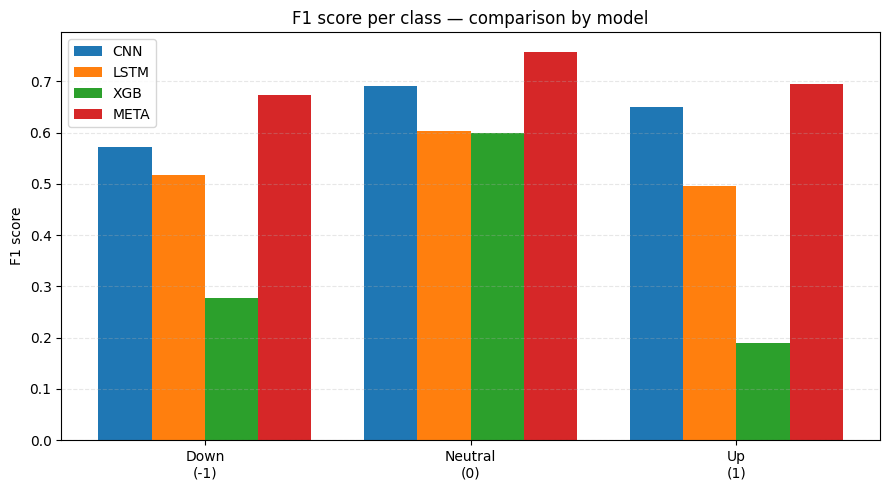

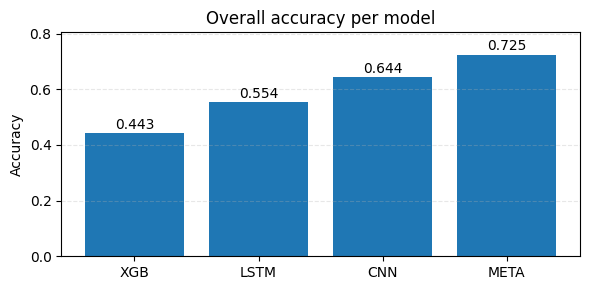


Best model by Macro_F1: META



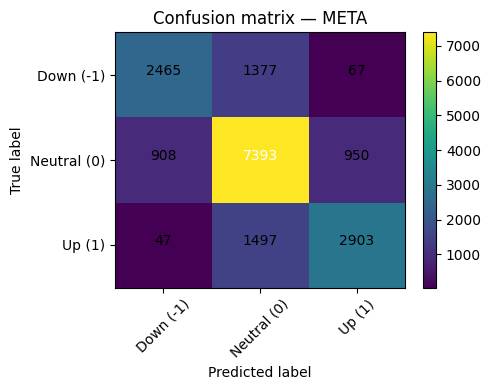

Saved model_metrics_summary.csv


In [82]:
# === Consolidated metrics & plots ===
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import os

# ---- config ----
oof_path = "oof_preds.pkl"    # created by the notebook
meta_model_path = "meta_learner.pkl"  # created by the notebook (optional)
inv_label_map = {0: -1.0, 1: 0.0, 2: 1.0}  # back to original labels; adjust if your mapping differs
class_names = ["Down (-1)", "Neutral (0)", "Up (1)"]
models_to_eval = ["cnn", "lstm", "xgb", "meta"]

# ---- load OOFs ----
if not os.path.exists(oof_path):
    raise FileNotFoundError(f"{oof_path} not found. Run the OOF generation cells (35-37 + save).")

data = joblib.load(oof_path)
# Expect keys: "oof_cnn", "oof_lstm", "oof_xgb", "y"
oof_cnn = data.get("oof_cnn")
oof_lstm = data.get("oof_lstm")
oof_xgb = data.get("oof_xgb")
y_all = data.get("y")

if y_all is None:
    raise RuntimeError("True labels 'y' not present in oof_preds.pkl - check saving step.")

# Normalize shape handling:
def probs_to_preds(arr):
    arr = np.asarray(arr)
    if arr.ndim == 1:
        return arr.astype(int)
    if arr.ndim == 2:
        return np.argmax(arr, axis=1)
    raise ValueError("Unexpected array shape for model outputs: %s" % (arr.shape,))

preds = {}
probs = {}
for name, arr in [("cnn", oof_cnn), ("lstm", oof_lstm), ("xgb", oof_xgb)]:
    if arr is None:
        print(f"[WARN] {name} OOF not found in {oof_path}.")
        continue
    arr = np.asarray(arr)
    probs[name] = arr
    preds[name] = probs_to_preds(arr)

# Meta (try to compute, if possible)
meta_available = False
if os.path.exists(meta_model_path):
    try:
        meta_model = joblib.load(meta_model_path)
        # Try to construct meta_X if saved inside oof file under a key (some notebooks store meta_X)
        meta_X = data.get("meta_X", None)
        if meta_X is None:
            # try to build from stacked probs if present
            if all(k in probs for k in ["cnn","lstm","xgb"]):
                stacked = np.hstack([probs["cnn"], probs["lstm"], probs["xgb"]])
                # if meta model expects extra features, this may fail — we fall back to skipping
                meta_X = stacked
        if meta_X is not None:
            meta_probs = meta_model.predict_proba(meta_X)
            preds["meta"] = np.argmax(meta_probs, axis=1)
            probs["meta"] = meta_probs
            meta_available = True
        else:
            print("[WARN] meta_X not found and could not be constructed; skipping meta evaluation.")
    except Exception as e:
        print("[WARN] failed to load/score meta model:", e)
else:
    print("[INFO] meta_learner.pkl not found; skipping meta evaluation.")

# convert y to ints if necessary
y_true = np.asarray(y_all).astype(int)

# ---- compute metrics per model ----
rows = []
per_class_f1 = {}
for m in ["cnn", "lstm", "xgb", "meta"]:
    if m not in preds:
        continue
    p = preds[m]
    acc = accuracy_score(y_true, p)
    prec = precision_score(y_true, p, average=None, labels=[0,1,2], zero_division=0)
    rec = recall_score(y_true, p, average=None, labels=[0,1,2], zero_division=0)
    f1s = f1_score(y_true, p, average=None, labels=[0,1,2], zero_division=0)
    macro_f1 = f1_score(y_true, p, average="macro", zero_division=0)
    rows.append({
        "Model": m.upper(),
        "Accuracy": acc,
        "Macro_F1": macro_f1,
        "F1_Down(-1)": f1s[0],
        "F1_Neutral(0)": f1s[1],
        "F1_Up(1)": f1s[2]
    })
    per_class_f1[m] = f1s

df_metrics = pd.DataFrame(rows).set_index("Model")
# Reorder rows (if meta missing it will be absent)
df_metrics = df_metrics.loc[[r for r in ["XGB","LSTM","CNN","META"] if r in df_metrics.index]]

# pretty print
pd.options.display.float_format = "{:0.4f}".format
print("\n=== Summary metrics per model ===")
display(df_metrics)

# ---- Table by class with precision/recall/f1 (full classification report) ----
print("\n=== Full classification reports ===")
for m in ["cnn","lstm","xgb","meta"]:
    if m not in preds:
        continue
    print(f"\n--- {m.upper()} ---")
    print(classification_report(y_true, preds[m], target_names=class_names, digits=4))

# ---- Plots: grouped bar chart of F1 per class & accuracy bar ----
models = list(per_class_f1.keys())
n_models = len(models)
classes_idx = [0,1,2]
width = 0.2
x = np.arange(len(classes_idx))

plt.figure(figsize=(9,5))
for i, m in enumerate(models):
    f1vals = per_class_f1[m]
    plt.bar(x + (i - (n_models-1)/2)*width, f1vals, width=width, label=m.upper())
plt.xticks(x, ["Down\n(-1)","Neutral\n(0)","Up\n(1)"])
plt.ylabel("F1 score")
plt.title("F1 score per class — comparison by model")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Accuracy bar chart
plt.figure(figsize=(6,3))
accs = [df_metrics.loc[m.upper(), "Accuracy"] for m in df_metrics.index]
plt.bar(df_metrics.index, accs)
plt.ylabel("Accuracy")
plt.title("Overall accuracy per model")
for i,v in enumerate(accs):
    plt.text(i, v+0.005, f"{v:.3f}", ha='center', va='bottom')
plt.ylim(0, max(accs)+0.08)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# ---- Confusion matrix heatmap for best model by Macro_F1 ----
best_model = df_metrics["Macro_F1"].idxmax().lower()
print(f"\nBest model by Macro_F1: {best_model.upper()}\n")

cm = confusion_matrix(y_true, preds[best_model], labels=[0,1,2])
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', aspect='auto')
plt.title(f"Confusion matrix — {best_model.upper()}")
plt.colorbar()
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.xticks([0,1,2], class_names, rotation=45)
plt.yticks([0,1,2], class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# ---- save table CSV ----
df_metrics.to_csv("model_metrics_summary.csv")
print("Saved model_metrics_summary.csv")


In [83]:
from google.colab import files
files.download("model_metrics_summary.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>